In [9]:
import json


# errors = {"ee0827d4c9bf80982241e8c3559dceb8b39063e4": {
#         "patch": "```diff\nPath: src/main/java/org/codehaus/plexus/archiver/zip/OffloadingOutputStream.java\n@@ -import org.apache.commons.io.output.ThresholdingOutputStream;\n+import org.apache.commons.io.output.DeferredFileOutputStream;\n@@ class OffloadingOutputStream extends ThresholdingOutputStream {\n-class OffloadingOutputStream extends ThresholdingOutputStream {\n+class OffloadingOutputStream {\n@@ /** * The output stream to which data will be written prior to the theshold * being reached. */ private ByteArrayOutputStream memoryOutputStream;\n-private OutputStream currentOutputStream;\n+private DeferredFileOutputStream currentOutputStream;\n@@ /** * The file to which output will be directed if the threshold is exceeded. */ private File outputFile = null;\n-private final String prefix;\n-private final String suffix;\n-private final File directory;\n+private final int threshold;\n@@ /** * True when close() has been called successfully. */ private boolean closed = false;\n@@ /** * Constructs an instance of this class which will trigger an event at the * specified threshold, and save data to a temporary file beyond that point. * * @param threshold The number of bytes at which to trigger an event. * @param prefix Prefix to use for the temporary file. * @param suffix Suffix to use for the temporary file. * @param directory Temporary file directory. * * @since 1.4 */ public OffloadingOutputStream( int threshold, String prefix, String suffix, File directory ) { this( threshold, null, prefix, suffix, directory ); if ( prefix == null ) { throw new IllegalArgumentException( \"Temporary file prefix is missing\" ); } }\n-public OffloadingOutputStream( int threshold, String prefix, String suffix, File directory ) {\n- this( threshold, null, prefix, suffix, directory );\n- if ( prefix == null ) {\n- throw new IllegalArgumentException( \"Temporary file prefix is missing\" );\n- }\n+public OffloadingOutputStream( int threshold, File outputFile ) {\n+ this.threshold = threshold;\n+ this.outputFile = outputFile;\n+ memoryOutputStream = new ByteArrayOutputStream( threshold / 10 );\n+ currentOutputStream = new DeferredFileOutputStream(threshold, outputFile);\n}\n@@ /** * Constructs an instance of this class which will trigger an event at the * specified threshold, and save data either to a file beyond that point. * * @param threshold The number of bytes at which to trigger an event. * @param outputFile The file to which data is saved beyond the threshold. * @param prefix Prefix to use for the temporary file. * @param suffix Suffix to use for the temporary file. * @param directory Temporary file directory. */ private OffloadingOutputStream( int threshold, File outputFile, String prefix, String suffix, File directory ) { super( threshold ); this.outputFile = outputFile; memoryOutputStream = new ByteArrayOutputStream( threshold / 10 ); currentOutputStream = memoryOutputStream; this.prefix = prefix; this.suffix = suffix; this.directory = directory; }\n-private OffloadingOutputStream( int threshold, File outputFile, String prefix, String suffix, File directory ) {\n- super( threshold );\n- this.outputFile = outputFile;\n- memoryOutputStream = new ByteArrayOutputStream( threshold / 10 );\n- currentOutputStream = memoryOutputStream;\n- this.prefix = prefix;\n- this.suffix = suffix;\n- this.directory = directory;\n+private OffloadingOutputStream( int threshold, File outputFile ) {\n+ this.threshold = threshold;\n+ this.outputFile = outputFile;\n+ memoryOutputStream = new ByteArrayOutputStream( threshold / 10 );\n+ currentOutputStream = new DeferredFileOutputStream(threshold, outputFile);\n}\n@@ /** * Returns the current output stream. This may be memory based or disk * based, depending on the current state with respect to the threshold. * * @return The underlying output stream. * * @exception java.io.IOException if an error occurs. */ @Override protected OutputStream getStream() throws IOException { return currentOutputStream; }\n-@Override\n-protected OutputStream getStream() throws IOException {\n- return currentOutputStream;\n-}\n@@ /** * Switches the underlying output stream from a memory based stream to one * that is backed by disk. This is the point at which we realise that too * much data is being written to keep in memory, so we elect to switch to * disk-based storage. * * @exception java.io.IOException if an error occurs. */ @Override protected void thresholdReached() throws IOException { if ( prefix != null ) { outputFile = File.createTempFile( prefix, suffix, directory ); } currentOutputStream = Files.newOutputStream( outputFile.toPath() ); }\n-@Override\n-protected void thresholdReached() throws IOException {\n- if ( prefix != null ) {\n- outputFile = File.createTempFile( prefix, suffix, directory );\n- }\n- currentOutputStream = Files.newOutputStream( outputFile.toPath() );\n-}\n@@ public InputStream getInputStream() throws IOException { InputStream memoryAsInput = memoryOutputStream.toInputStream(); if ( outputFile == null ) { return memoryAsInput; } return new SequenceInputStream( memoryAsInput, Files.newInputStream( outputFile.toPath() ) ); }\n-public InputStream getInputStream() throws IOException {\n- InputStream memoryAsInput = memoryOutputStream.toInputStream();\n- if ( outputFile == null ) {\n- return memoryAsInput;\n- }\n- return new SequenceInputStream( memoryAsInput, Files.newInputStream( outputFile.toPath() ) );\n+public InputStream getInputStream() throws IOException {\n+ if (currentOutputStream.isInMemory()) {\n+ return new ByteArrayInputStream(currentOutputStream.getData());\n+ } else {\n+ return new SequenceInputStream(new ByteArrayInputStream(currentOutputStream.getData()), new FileInputStream(currentOutputStream.getFile()));\n+ }\n}\n@@ /** * Returns the data for this output stream as an array of bytes, assuming * that the data has been retained in memory. If the data was written to * disk, this method returns <code>null</code>. * * @return The data for this output stream, or <code>null</code> if no such * data is available. */ public byte[] getData() { if ( memoryOutputStream != null ) { return memoryOutputStream.toByteArray(); } return null; }\n-public byte[] getData() {\n- if ( memoryOutputStream != null ) {\n- return memoryOutputStream.toByteArray();\n- }\n- return null;\n+public byte[] getData() {\n+ return currentOutputStream.getData();\n}\n@@ /** * Returns either the output file specified in the constructor or * the temporary file created or null. * <p> * If the constructor specifying the file is used then it returns that * same output file, even when threshold has not been reached. * <p> * If constructor specifying a temporary file prefix/suffix is used * then the temporary file created once the threshold is reached is returned * If the threshold was not reached then <code>null</code> is returned. * * @return The file for this output stream, or <code>null</code> if no such * file exists. */ public File getFile() { return outputFile; }\n-public File getFile() {\n- return outputFile;\n+public File getFile() {\n+ return currentOutputStream.getFile();\n}\n@@ /** * Closes underlying output stream, and mark this as closed * * @exception java.io.IOException if an error occurs. */ @Override public void close() throws IOException { super.close(); closed = true; currentOutputStream.close(); }\n-@Override\n-public void close() throws IOException {\n- super.close();\n- closed = true;\n- currentOutputStream.close();\n+@Override\n+public void close() throws IOException {\n+ currentOutputStream.close();\n+ closed = true;\n}\n```\n\nThis diff should address the changes required due to the API changes in the dependency. The `ThresholdingOutputStream` has been replaced with `DeferredFileOutputStream` and the necessary adjustments have been made to the methods and constructors.",
#         "error": "Error during compilation: [ERROR] Failed to execute goal org.apache.maven.plugins:maven-compiler-plugin:3.10.1:compile (default-compile) on project plexus-archiver: Compilation failure: Compilation failure:\n[ERROR] /mnt/repo/src/main/java/org/codehaus/plexus/archiver/zip/AbstractZipUnArchiver.java:[28,35] cannot find symbol\n[ERROR]   symbol:   class BoundedInputStream\n[ERROR]   location: package org.apache.commons.io.input\n[ERROR] /mnt/repo/src/main/java/org/codehaus/plexus/archiver/zip/OffloadingOutputStream.java:[27,36] cannot find symbol\n[ERROR]   symbol:   class ThresholdingOutputStream\n[ERROR]   location: package org.apache.commons.io.output\n[ERROR] /mnt/repo/src/main/java/org/codehaus/plexus/archiver/zip/OffloadingOutputStream.java:[32,38] cannot find symbol\n[ERROR]   symbol: class ThresholdingOutputStream\n[ERROR] /mnt/repo/src/main/java/org/codehaus/plexus/archiver/zip/ByteArrayOutputStream.java:[29,35] cannot find symbol\n[ERROR]   symbol:   class ClosedInputStream\n[ERROR]   location: package org.apache.commons.io.input\n[ERROR] /mnt/repo/src/main/java/org/codehaus/plexus/archiver/jar/JarToolModularJarArchiver.java:[41,36] cannot find symbol\n[ERROR]   symbol:   class NullPrintStream\n[ERROR]   location: package org.apache.commons.io.output\n[ERROR] /mnt/repo/src/main/java/org/codehaus/plexus/archiver/zip/AbstractZipUnArchiver.java:[204,25] cannot find symbol\n[ERROR]   symbol:   class BoundedInputStream\n[ERROR]   location: class org.codehaus.plexus.archiver.zip.AbstractZipUnArchiver\n[ERROR] /mnt/repo/src/main/java/org/codehaus/plexus/archiver/zip/AbstractZipUnArchiver.java:[204,54] cannot find symbol\n[ERROR]   symbol:   class BoundedInputStream\n[ERROR]   location: class org.codehaus.plexus.archiver.zip.AbstractZipUnArchiver\n[ERROR] /mnt/repo/src/main/java/org/codehaus/plexus/archiver/zip/AbstractZipUnArchiver.java:[211,46] cannot find symbol\n[ERROR]   symbol:   method getByteCount()\n[ERROR]   location: variable cis of type org.apache.commons.io.input.CountingInputStream\n[ERROR] /mnt/repo/src/main/java/org/codehaus/plexus/archiver/zip/OffloadingOutputStream.java:[129,5] method does not override or implement a method from a supertype\n[ERROR] /mnt/repo/src/main/java/org/codehaus/plexus/archiver/zip/OffloadingOutputStream.java:[143,5] method does not override or implement a method from a supertype\n[ERROR] /mnt/repo/src/main/java/org/codehaus/plexus/archiver/zip/OffloadingOutputStream.java:[207,5] method does not override or implement a method from a supertype\n[ERROR] /mnt/repo/src/main/java/org/codehaus/plexus/archiver/zip/OffloadingOutputStream.java:[210,9] cannot find symbol\n[ERROR]   symbol:   variable super\n[ERROR]   location: class org.codehaus.plexus.archiver.zip.OffloadingOutputStream\n[ERROR] /mnt/repo/src/main/java/org/codehaus/plexus/archiver/zip/ByteArrayOutputStream.java:[401,24] cannot find symbol\n[ERROR]   symbol:   class ClosedInputStream\n[ERROR]   location: class org.codehaus.plexus.archiver.zip.ByteArrayOutputStream\n[ERROR] /mnt/repo/src/main/java/org/codehaus/plexus/archiver/jar/JarToolModularJarArchiver.java:[300,43] cannot find symbol\n[ERROR]   symbol:   variable NullPrintStream\n[ERROR]   location: class org.codehaus.plexus.archiver.jar.JarToolModularJarArchiver\n[ERROR] /mnt/repo/src/main/java/org/codehaus/plexus/archiver/zip/DeferredScatterOutputStream.java:[44,13] cannot find symbol\n[ERROR]   symbol:   method write(byte[],int,int)\n[ERROR]   location: variable dfos of type org.codehaus.plexus.archiver.zip.OffloadingOutputStream\n[ERROR] -> [Help 1]",
#         "input": {
#             "initial_error_lines": "[ERROR] Failed to execute goal org.apache.maven.plugins:maven-compiler-plugin:3.10.1:compile (default-compile) on project plexus-archiver: Compilation failure: Compilation failure:\n[ERROR] /plexus-archiver/src/main/java/org/codehaus/plexus/archiver/zip/ByteArrayOutputStream.java:[29,35] cannot find symbol\n[ERROR]   symbol:   class ClosedInputStream\n[ERROR]   location: package org.apache.commons.io.input\n[ERROR] /plexus-archiver/src/main/java/org/codehaus/plexus/archiver/zip/AbstractZipUnArchiver.java:[28,35] cannot find symbol\n[ERROR]   symbol:   class BoundedInputStream\n[ERROR]   location: package org.apache.commons.io.input\n[ERROR] /plexus-archiver/src/main/java/org/codehaus/plexus/archiver/jar/JarToolModularJarArchiver.java:[41,36] cannot find symbol\n[ERROR]   symbol:   class NullPrintStream\n[ERROR]   location: package org.apache.commons.io.output\n[ERROR] /plexus-archiver/src/main/java/org/codehaus/plexus/archiver/zip/OffloadingOutputStream.java:[27,36] cannot find symbol\n[ERROR]   symbol:   class ThresholdingOutputStream\n[ERROR]   location: package org.apache.commons.io.output\n[ERROR] /plexus-archiver/src/main/java/org/codehaus/plexus/archiver/zip/OffloadingOutputStream.java:[32,38] cannot find symbol\n[ERROR]   symbol: class ThresholdingOutputStream\n[ERROR] /plexus-archiver/src/main/java/org/codehaus/plexus/archiver/zip/ByteArrayOutputStream.java:[401,24] cannot find symbol\n[ERROR]   symbol:   class ClosedInputStream\n[ERROR]   location: class org.codehaus.plexus.archiver.zip.ByteArrayOutputStream\n[ERROR] /plexus-archiver/src/main/java/org/codehaus/plexus/archiver/zip/AbstractZipUnArchiver.java:[204,25] cannot find symbol\n[ERROR]   symbol:   class BoundedInputStream\n[ERROR]   location: class org.codehaus.plexus.archiver.zip.AbstractZipUnArchiver\n[ERROR] /plexus-archiver/src/main/java/org/codehaus/plexus/archiver/zip/AbstractZipUnArchiver.java:[204,54] cannot find symbol\n[ERROR]   symbol:   class BoundedInputStream\n[ERROR]   location: class org.codehaus.plexus.archiver.zip.AbstractZipUnArchiver\n[ERROR] /plexus-archiver/src/main/java/org/codehaus/plexus/archiver/zip/AbstractZipUnArchiver.java:[211,46] cannot find symbol\n[ERROR]   symbol:   method getByteCount()\n[ERROR]   location: variable cis of type org.apache.commons.io.input.CountingInputStream\n[ERROR] /plexus-archiver/src/main/java/org/codehaus/plexus/archiver/jar/JarToolModularJarArchiver.java:[300,43] cannot find symbol\n[ERROR]   symbol:   variable NullPrintStream\n[ERROR]   location: class org.codehaus.plexus.archiver.jar.JarToolModularJarArchiver\n[ERROR] /plexus-archiver/src/main/java/org/codehaus/plexus/archiver/zip/DeferredScatterOutputStream.java:[44,13] cannot find symbol\n[ERROR]   symbol:   method write(byte[],int,int)\n[ERROR]   location: variable dfos of type org.codehaus.plexus.archiver.zip.OffloadingOutputStream\n[ERROR] /plexus-archiver/src/main/java/org/codehaus/plexus/archiver/zip/OffloadingOutputStream.java:[129,5] method does not override or implement a method from a supertype\n[ERROR] /plexus-archiver/src/main/java/org/codehaus/plexus/archiver/zip/OffloadingOutputStream.java:[143,5] method does not override or implement a method from a supertype\n[ERROR] /plexus-archiver/src/main/java/org/codehaus/plexus/archiver/zip/OffloadingOutputStream.java:[207,5] method does not override or implement a method from a supertype\n[ERROR] /plexus-archiver/src/main/java/org/codehaus/plexus/archiver/zip/OffloadingOutputStream.java:[210,9] cannot find symbol\n[ERROR]   symbol:   variable super\n[ERROR]   location: class org.codehaus.plexus.archiver.zip.OffloadingOutputStream\n[ERROR] -> [Help 1]",
#             "api_changes": "[\"getByteCount()\", \"write(byte[],int,int)\", \"org.apache.commons.io.input.BoundedInputStream(java.io.InputStream,long)\", \"org.apache.commons.io.input.ClosedInputStream()\", \"close()\"]",
#             "repo_slug": "codehaus-plexus/plexus-archiver",
#             "commit_hash": "ee0827d4c9bf80982241e8c3559dceb8b39063e4",
#             "reproduction_command": "mvn clean test -B",
#             "updated_dependency_diff": "diff --git a/pom.xml b/pom.xml\nindex 894e13d42..61d36834c 100644\n--- a/pom.xml\n+++ b/pom.xml\n@@ -73,7 +73,7 @@\n     <dependency>\n       <groupId>commons-io</groupId>\n       <artifactId>commons-io</artifactId>\n-      <version>2.11.0</version>\n+      <version>20030203.000550</version>\n     </dependency>\n     <dependency>\n       <groupId>org.apache.commons</groupId>\n",
#             "file_in_scope": "src/main/java/org/codehaus/plexus/archiver/zip/OffloadingOutputStream.java",
#             "param_token_count": 1193,
#             "prepared_file": "/*\n *  Licensed to the Apache Software Foundation (ASF) under one or more\n *  contributor license agreements.  See the NOTICE file distributed with\n *  this work for additional information regarding copyright ownership.\n *  The ASF licenses this file to You under the Apache License, Version 2.0\n *  (the \"License\"); you may not use this file except in compliance with\n *  the License.  You may obtain a copy of the License at\n *\n *      http://www.apache.org/licenses/LICENSE-2.0\n *\n *  Unless required by applicable law or agreed to in writing, software\n *  distributed under the License is distributed on an \"AS IS\" BASIS,\n *  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.\n *  See the License for the specific language governing permissions and\n *  limitations under the License.\n *\n */\npackage org.codehaus.plexus.archiver.zip;\n\nimport java.io.File;\nimport java.io.IOException;\nimport java.io.InputStream;\nimport java.io.OutputStream;\nimport java.io.SequenceInputStream;\nimport java.nio.file.Files;\n\nimport org.apache.commons.io.output.ThresholdingOutputStream;\n\n/**\n * Offloads to disk when a given memory consumption has been reacehd\n */\nclass OffloadingOutputStream extends ThresholdingOutputStream\n{\n\n    // ----------------------------------------------------------- Data members\n\n    /**\n     * The output stream to which data will be written prior to the theshold\n     * being reached.\n     */\n    private ByteArrayOutputStream memoryOutputStream;\n\n    /**\n     * The output stream to which data will be written at any given time. This\n     * will always be one of <code>memoryOutputStream</code> or\n     * <code>diskOutputStream</code>.\n     */\n    private OutputStream currentOutputStream;\n\n    /**\n     * The file to which output will be directed if the threshold is exceeded.\n     */\n    private File outputFile = null;\n\n    /**\n     * The temporary file prefix.\n     */\n    private final String prefix;\n\n    /**\n     * The temporary file suffix.\n     */\n    private final String suffix;\n\n    /**\n     * The directory to use for temporary files.\n     */\n    private final File directory;\n\n    /**\n     * True when close() has been called successfully.\n     */\n    private boolean closed = false;\n\n    // ----------------------------------------------------------- Constructors\n\n    /**\n     * Constructs an instance of this class which will trigger an event at the\n     * specified threshold, and save data to a temporary file beyond that point.\n     *\n     * @param threshold The number of bytes at which to trigger an event.\n     * @param prefix Prefix to use for the temporary file.\n     * @param suffix Suffix to use for the temporary file.\n     * @param directory Temporary file directory.\n     *\n     * @since 1.4\n     */\n    public OffloadingOutputStream( int threshold, String prefix, String suffix, File directory )\n    {\n        this( threshold, null, prefix, suffix, directory );\n        if ( prefix == null )\n        {\n            throw new IllegalArgumentException( \"Temporary file prefix is missing\" );\n        }\n    }\n\n    /**\n     * Constructs an instance of this class which will trigger an event at the\n     * specified threshold, and save data either to a file beyond that point.\n     *\n     * @param threshold The number of bytes at which to trigger an event.\n     * @param outputFile The file to which data is saved beyond the threshold.\n     * @param prefix Prefix to use for the temporary file.\n     * @param suffix Suffix to use for the temporary file.\n     * @param directory Temporary file directory.\n     */\n    private OffloadingOutputStream( int threshold, File outputFile, String prefix, String suffix, File directory )\n    {\n        super( threshold );\n        this.outputFile = outputFile;\n\n        memoryOutputStream = new ByteArrayOutputStream( threshold / 10 );\n        currentOutputStream = memoryOutputStream;\n        this.prefix = prefix;\n        this.suffix = suffix;\n        this.directory = directory;\n    }\n\n    // --------------------------------------- ThresholdingOutputStream methods\n\n    /**\n     * Returns the current output stream. This may be memory based or disk\n     * based, depending on the current state with respect to the threshold.\n     *\n     * @return The underlying output stream.\n     *\n     * @exception java.io.IOException if an error occurs.\n     */\n    @Override\n    protected OutputStream getStream() throws IOException\n    {\n        return currentOutputStream;\n    }\n\n    /**\n     * Switches the underlying output stream from a memory based stream to one\n     * that is backed by disk. This is the point at which we realise that too\n     * much data is being written to keep in memory, so we elect to switch to\n     * disk-based storage.\n     *\n     * @exception java.io.IOException if an error occurs.\n     */\n    @Override\n    protected void thresholdReached() throws IOException\n    {\n        if ( prefix != null )\n        {\n            outputFile = File.createTempFile( prefix, suffix, directory );\n        }\n        currentOutputStream = Files.newOutputStream( outputFile.toPath() );\n    }\n\n    public InputStream getInputStream() throws IOException\n    {\n\n        InputStream memoryAsInput = memoryOutputStream.toInputStream();\n        if ( outputFile == null )\n        {\n            return memoryAsInput;\n        }\n        return new SequenceInputStream( memoryAsInput, Files.newInputStream( outputFile.toPath() ) );\n    }\n\n    // --------------------------------------------------------- Public methods\n\n    /**\n     * Returns the data for this output stream as an array of bytes, assuming\n     * that the data has been retained in memory. If the data was written to\n     * disk, this method returns <code>null</code>.\n     *\n     * @return The data for this output stream, or <code>null</code> if no such\n     * data is available.\n     */\n    public byte[] getData()\n    {\n        if ( memoryOutputStream != null )\n        {\n            return memoryOutputStream.toByteArray();\n        }\n        return null;\n    }\n\n    /**\n     * Returns either the output file specified in the constructor or\n     * the temporary file created or null.\n     * <p>\n     * If the constructor specifying the file is used then it returns that\n     * same output file, even when threshold has not been reached.\n     * <p>\n     * If constructor specifying a temporary file prefix/suffix is used\n     * then the temporary file created once the threshold is reached is returned\n     * If the threshold was not reached then <code>null</code> is returned.\n     *\n     * @return The file for this output stream, or <code>null</code> if no such\n     * file exists.\n     */\n    public File getFile()\n    {\n        return outputFile;\n    }\n\n    /**\n     * Closes underlying output stream, and mark this as closed\n     *\n     * @exception java.io.IOException if an error occurs.\n     */\n    @Override\n    public void close() throws IOException\n    {\n        super.close();\n        closed = true;\n        currentOutputStream.close();\n    }\n\n}\n"
#         },
#         "final_assumed_token_count": 2622,
#         "raw_output": "```diff\nPath: src/main/java/org/codehaus/plexus/archiver/zip/OffloadingOutputStream.java\n@@ -import org.apache.commons.io.output.ThresholdingOutputStream;\n+import org.apache.commons.io.output.DeferredFileOutputStream;\n@@ class OffloadingOutputStream extends ThresholdingOutputStream {\n-class OffloadingOutputStream extends ThresholdingOutputStream {\n+class OffloadingOutputStream {\n@@ /** * The output stream to which data will be written prior to the theshold * being reached. */ private ByteArrayOutputStream memoryOutputStream;\n-private OutputStream currentOutputStream;\n+private DeferredFileOutputStream currentOutputStream;\n@@ /** * The file to which output will be directed if the threshold is exceeded. */ private File outputFile = null;\n-private final String prefix;\n-private final String suffix;\n-private final File directory;\n+private final int threshold;\n@@ /** * True when close() has been called successfully. */ private boolean closed = false;\n@@ /** * Constructs an instance of this class which will trigger an event at the * specified threshold, and save data to a temporary file beyond that point. * * @param threshold The number of bytes at which to trigger an event. * @param prefix Prefix to use for the temporary file. * @param suffix Suffix to use for the temporary file. * @param directory Temporary file directory. * * @since 1.4 */ public OffloadingOutputStream( int threshold, String prefix, String suffix, File directory ) { this( threshold, null, prefix, suffix, directory ); if ( prefix == null ) { throw new IllegalArgumentException( \"Temporary file prefix is missing\" ); } }\n-public OffloadingOutputStream( int threshold, String prefix, String suffix, File directory ) {\n- this( threshold, null, prefix, suffix, directory );\n- if ( prefix == null ) {\n- throw new IllegalArgumentException( \"Temporary file prefix is missing\" );\n- }\n+public OffloadingOutputStream( int threshold, File outputFile ) {\n+ this.threshold = threshold;\n+ this.outputFile = outputFile;\n+ memoryOutputStream = new ByteArrayOutputStream( threshold / 10 );\n+ currentOutputStream = new DeferredFileOutputStream(threshold, outputFile);\n}\n@@ /** * Constructs an instance of this class which will trigger an event at the * specified threshold, and save data either to a file beyond that point. * * @param threshold The number of bytes at which to trigger an event. * @param outputFile The file to which data is saved beyond the threshold. * @param prefix Prefix to use for the temporary file. * @param suffix Suffix to use for the temporary file. * @param directory Temporary file directory. */ private OffloadingOutputStream( int threshold, File outputFile, String prefix, String suffix, File directory ) { super( threshold ); this.outputFile = outputFile; memoryOutputStream = new ByteArrayOutputStream( threshold / 10 ); currentOutputStream = memoryOutputStream; this.prefix = prefix; this.suffix = suffix; this.directory = directory; }\n-private OffloadingOutputStream( int threshold, File outputFile, String prefix, String suffix, File directory ) {\n- super( threshold );\n- this.outputFile = outputFile;\n- memoryOutputStream = new ByteArrayOutputStream( threshold / 10 );\n- currentOutputStream = memoryOutputStream;\n- this.prefix = prefix;\n- this.suffix = suffix;\n- this.directory = directory;\n+private OffloadingOutputStream( int threshold, File outputFile ) {\n+ this.threshold = threshold;\n+ this.outputFile = outputFile;\n+ memoryOutputStream = new ByteArrayOutputStream( threshold / 10 );\n+ currentOutputStream = new DeferredFileOutputStream(threshold, outputFile);\n}\n@@ /** * Returns the current output stream. This may be memory based or disk * based, depending on the current state with respect to the threshold. * * @return The underlying output stream. * * @exception java.io.IOException if an error occurs. */ @Override protected OutputStream getStream() throws IOException { return currentOutputStream; }\n-@Override\n-protected OutputStream getStream() throws IOException {\n- return currentOutputStream;\n-}\n@@ /** * Switches the underlying output stream from a memory based stream to one * that is backed by disk. This is the point at which we realise that too * much data is being written to keep in memory, so we elect to switch to * disk-based storage. * * @exception java.io.IOException if an error occurs. */ @Override protected void thresholdReached() throws IOException { if ( prefix != null ) { outputFile = File.createTempFile( prefix, suffix, directory ); } currentOutputStream = Files.newOutputStream( outputFile.toPath() ); }\n-@Override\n-protected void thresholdReached() throws IOException {\n- if ( prefix != null ) {\n- outputFile = File.createTempFile( prefix, suffix, directory );\n- }\n- currentOutputStream = Files.newOutputStream( outputFile.toPath() );\n-}\n@@ public InputStream getInputStream() throws IOException { InputStream memoryAsInput = memoryOutputStream.toInputStream(); if ( outputFile == null ) { return memoryAsInput; } return new SequenceInputStream( memoryAsInput, Files.newInputStream( outputFile.toPath() ) ); }\n-public InputStream getInputStream() throws IOException {\n- InputStream memoryAsInput = memoryOutputStream.toInputStream();\n- if ( outputFile == null ) {\n- return memoryAsInput;\n- }\n- return new SequenceInputStream( memoryAsInput, Files.newInputStream( outputFile.toPath() ) );\n+public InputStream getInputStream() throws IOException {\n+ if (currentOutputStream.isInMemory()) {\n+ return new ByteArrayInputStream(currentOutputStream.getData());\n+ } else {\n+ return new SequenceInputStream(new ByteArrayInputStream(currentOutputStream.getData()), new FileInputStream(currentOutputStream.getFile()));\n+ }\n}\n@@ /** * Returns the data for this output stream as an array of bytes, assuming * that the data has been retained in memory. If the data was written to * disk, this method returns <code>null</code>. * * @return The data for this output stream, or <code>null</code> if no such * data is available. */ public byte[] getData() { if ( memoryOutputStream != null ) { return memoryOutputStream.toByteArray(); } return null; }\n-public byte[] getData() {\n- if ( memoryOutputStream != null ) {\n- return memoryOutputStream.toByteArray();\n- }\n- return null;\n+public byte[] getData() {\n+ return currentOutputStream.getData();\n}\n@@ /** * Returns either the output file specified in the constructor or * the temporary file created or null. * <p> * If the constructor specifying the file is used then it returns that * same output file, even when threshold has not been reached. * <p> * If constructor specifying a temporary file prefix/suffix is used * then the temporary file created once the threshold is reached is returned * If the threshold was not reached then <code>null</code> is returned. * * @return The file for this output stream, or <code>null</code> if no such * file exists. */ public File getFile() { return outputFile; }\n-public File getFile() {\n- return outputFile;\n+public File getFile() {\n+ return currentOutputStream.getFile();\n}\n@@ /** * Closes underlying output stream, and mark this as closed * * @exception java.io.IOException if an error occurs. */ @Override public void close() throws IOException { super.close(); closed = true; currentOutputStream.close(); }\n-@Override\n-public void close() throws IOException {\n- super.close();\n- closed = true;\n- currentOutputStream.close();\n+@Override\n+public void close() throws IOException {\n+ currentOutputStream.close();\n+ closed = true;\n}\n```\n\nThis diff should address the changes required due to the API changes in the dependency. The `ThresholdingOutputStream` has been replaced with `DeferredFileOutputStream` and the necessary adjustments have been made to the methods and constructors."
#     },}

with open("errors.json", "r") as f:
    errors = json.load(f)

    # filter for b6a48a6e557fad1ceda680618e0a34c7b8c5c087
    # errors = {k: v for k, v in errors.items() if k == 'b6a48a6e557fad1ceda680618e0a34c7b8c5c087'}

# for commit_hash in errors:
#     patch = errors[commit_hash]['patch']
#     raw_output = errors[commit_hash]['raw_output']
#     input_file = errors[commit_hash]['input']['prepared_file']

In [10]:
import os
from pathlib import Path
import tempfile
import unittest
from unittest.mock import patch

from masterthesis.agent.aider.search_replace import all_preprocs

from masterthesis.agent.aider.AdvancedDiffAgent import (
    UnifiedDiffCoder,
    apply_partial_hunk,
)
from masterthesis.agent.aider.search_replace import (
    flexible_search_and_replace,
    search_and_replace,
)

# Assuming UnifiedDiffCoder and all necessary methods are imported from your module
# from your_module import UnifiedDiffCoder, apply_partial_hunk

strategy_success = {}


# Define a test class inheriting from unittest.TestCase
class TestUnifiedDiffCoder(unittest.TestCase):

    # def setUp(self):
    # self.repo_dir = "/path/to/repo"  # replace with your actual repo path
    # self.coder = UnifiedDiffCoder(self.repo_dir)
    # Example errors dictionary
    # self.errors = {
    #     "commit_hash1": {
    #         "patch": """
    #         --- a/sample.txt
    #         +++ b/sample.txt
    #         @@ -1,3 +1,3 @@
    #         -old line
    #         +new line
    #         unchanged line
    #         """,
    #         "raw_output": "example raw output",
    #         "input": {
    #             "prepared_file": "sample.txt"
    #         }
    #     },
    #     # Add more commit_hash entries as needed
    # }

    def test_apply_patch_with_strategy_results(self):
        # Define the mock function
        def mock_apply_partial_hunk(
            content,
            preceding_context,
            changes,
            following_context,
            commit_hash,
            output_strategy_results=False,
        ):

            res, strat = apply_partial_hunk(
                content,
                preceding_context,
                changes,
                following_context,
                output_strategy_results=True,
            )
            if commit_hash not in strategy_success:

                strategy_success[commit_hash] = {}

            for result in strat:

                strategy = result["strategy"]

                success = result["success"]

                strategy_success[commit_hash][strategy] = success
            return res

        def mock_flexi_just_search_and_replace(texts, commit_hash):
            strategies = [
                (search_and_replace, all_preprocs),
            ]

            res, strat = flexible_search_and_replace(
                texts, strategies, output_strategy_results=True
            )

            for result in strat:
                strategy = result["strategy"]
                success = result["success"]
                strategy_success[commit_hash][strategy] = success
            return res

        for commit_hash in errors:
            with (
                patch(
                    "masterthesis.agent.aider.AdvancedDiffAgent.apply_partial_hunk",
                    side_effect=lambda content, preceding_context, changes, following_context, output_strategy_results=False: mock_apply_partial_hunk(
                        content,
                        preceding_context,
                        changes,
                        following_context,
                        commit_hash,
                        output_strategy_results,
                    ),
                ) as mock_method1,
                patch(
                    "masterthesis.agent.aider.AdvancedDiffAgent.flexi_just_search_and_replace",
                    side_effect=lambda texts: mock_flexi_just_search_and_replace(
                        texts, commit_hash
                    ),
                ) as mock_method2,
            ):
                with tempfile.TemporaryDirectory() as tmpdir:
                    if commit_hash not in strategy_success:
                        strategy_success[commit_hash] = {}
                    file_in_scope = errors[commit_hash]["input"]["file_in_scope"]
                    patch_content = errors[commit_hash]["patch"]
                    input_file = errors[commit_hash]["input"]["prepared_file"]

                    coder = UnifiedDiffCoder(tmpdir)
                    os.makedirs(
                        Path(tmpdir) / Path(file_in_scope).parent, exist_ok=True
                    )
                    with open(Path(tmpdir) / file_in_scope, "w") as f:
                        f.write(input_file)

                    success, modified_content = coder.apply_edits(patch_content)

                    if success:
                        print("Patch applied successfully.")
                        if strategy_success[commit_hash] == {}:
                            strategy = "direct_apply"
                            success = True
                            strategy_success[commit_hash][strategy] = success
                    else:

                        print("Failed to apply patch.")


# Run the test
# if __name__ == "__main__":
unittest.main(argv=["first-arg-is-ignored"], exit=False)

strategy_success

E
ERROR: test_apply_patch_with_strategy_results (__main__.TestUnifiedDiffCoder.test_apply_patch_with_strategy_results)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "/tmp/colima/ipykernel_13903/4020828086.py", line 92, in test_apply_patch_with_strategy_results
    success, modified_content = coder.apply_edits(patch_content)
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/anon/Projects/masterthesis/masterthesis/agent/aider/AdvancedDiffAgent.py", line 97, in apply_edits
    for path, _ in raw_edits:
                      ^^^^^^^^
  File "/Users/anon/Projects/masterthesis/masterthesis/agent/aider/AdvancedDiffAgent.py", line 78, in get_edits
  File "/Users/anon/Projects/masterthesis/masterthesis/agent/aider/AdvancedDiffAgent.py", line 534, in find_diffs
    current_slice = content_lines[i : i + len(context_lines)]
       ^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attribute 'end

{'0305beafdecb0b28f7c94264ed20cdc4e41ff067': {}}

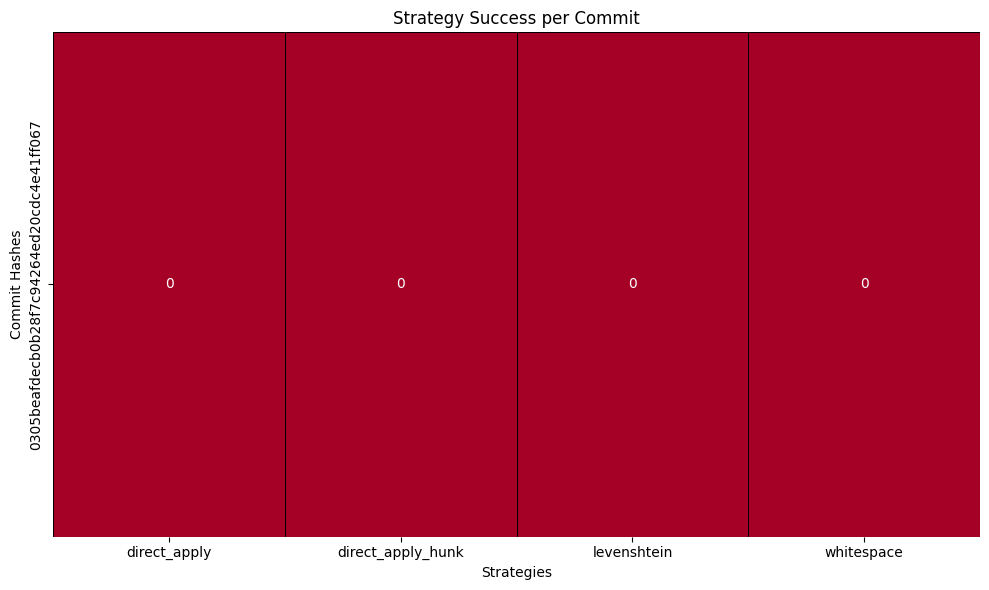

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Custom order for strategies
base_order = ["direct_apply", "direct_apply_hunk", "levenshtein", "whitespace"]

# Convert the data to a DataFrame
data = []
all_strategies = set(base_order)  # Start with the base order strategies
for commit_hash, strategies in strategy_success.items():
    all_strategies.update(strategies.keys())  # Include any other strategies found

# Convert the data ensuring all strategies are present
for commit_hash, strategies in strategy_success.items():
    row = {strategy: strategies.get(strategy, 0) for strategy in all_strategies}
    row["commit_hash"] = commit_hash
    data.append(row)

df = pd.DataFrame(data)
df.set_index("commit_hash", inplace=True)

# Identify all search_and_replace_* columns
search_and_replace_cols = [col for col in df.columns if col.startswith("s_r_")]

# Create the final column order
final_order = base_order[:2] + search_and_replace_cols + base_order[2:]

# Ensure all columns from final_order are in the DataFrame, even if they are missing
for col in final_order:
    if col not in df.columns:
        df[col] = 0

# Reorder the DataFrame columns according to the final order
df = df[final_order]

# Replace True/False with 1/0 for the heatmap (if any boolean values exist)
df = df.replace({True: 1, False: 0})


summary = df.sum().to_frame(name="Success Count")
summary["Failure Count"] = len(df) - summary["Success Count"]
summary.index.name = "Strategy"

plt.figure(figsize=(10, 6))
sns.heatmap(
    df, annot=True, cmap="RdYlGn", cbar=False, linewidths=0.5, linecolor="black"
)
plt.xlabel("Strategies")
plt.ylabel("Commit Hashes")
plt.title("Strategy Success per Commit")
plt.tight_layout()
plt.show()

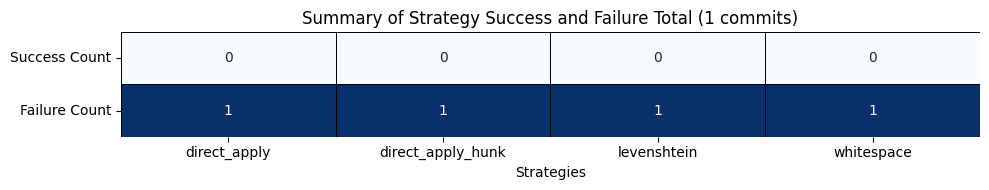

In [12]:
# Calculate the summary
summary = df.sum().to_frame(name="Success Count")
summary["Failure Count"] = len(df) - summary["Success Count"]
summary.index.name = "Strategy"


# Create the summary heatmap
plt.figure(figsize=(10, 2))
sns.heatmap(
    summary.T, annot=True, cmap="Blues", cbar=False, linewidths=0.5, linecolor="black"
)
plt.xlabel("Strategies")
plt.title(f"Summary of Strategy Success and Failure Total ({len(df)} commits)")
plt.tight_layout()
plt.show()

In [ ]:
import json
import pandas as pd


def extract_spans_grouped_by_trace_id(file_path):
    spans_grouped = {}
    with open(file_path, "r") as file:
        for line in file:
            span = json.loads(line)
            trace_id = span.get("context", {}).get("trace_id")
            if trace_id not in spans_grouped:
                spans_grouped[trace_id] = []
            span_info = {
                "name": span.get("name"),
                "start_time": span.get("start_time"),
                "end_time": span.get("end_time"),
                "status": span.get("status", {}).get("status_code"),
                "attributes": span.get("attributes"),
                "events": span.get("events"),
            }
            spans_grouped[trace_id].append(span_info)
    return spans_grouped


def spans_to_dataframe(spans_grouped_by_trace_id):
    grouped_data = []
    for trace_id, spans in spans_grouped_by_trace_id.items():
        for span in spans:
            grouped_data.append({"trace_id": trace_id, **span})
    return pd.DataFrame(grouped_data)


def main():
    file_path = "trace.json"  # Update this path to your file location
    spans_grouped_by_trace_id = extract_spans_grouped_by_trace_id(file_path)
    df_grouped_spans = spans_to_dataframe(spans_grouped_by_trace_id)
    df_grouped_spans.to_csv("grouped_spans.csv", index=False)
    print("Grouped spans have been saved to 'grouped_spans.csv'")